In [1]:
import cv2
import numpy as np
import os.path as op
import matplotlib.pyplot as plt

In [2]:
data_path = op.join('.', 'images', 'nightsight')
img_type = '.JPG'
img_set = []
exposure_time = []

In [3]:
def imshow(img, cmap=None):
    plt.imshow(img, cmap)
    plt.show()

./images/nightsight/00.JPG
0.0004


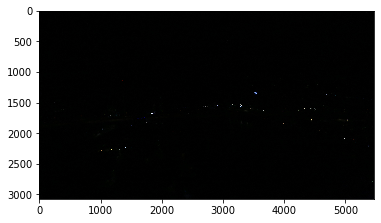

./images/nightsight/01.JPG
0.001


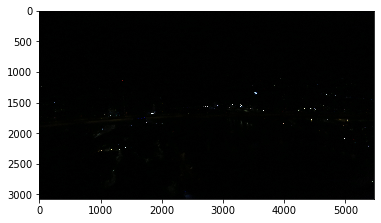

./images/nightsight/02.JPG
0.002


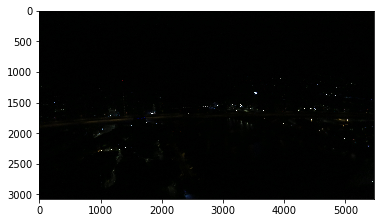

./images/nightsight/03.JPG
0.004


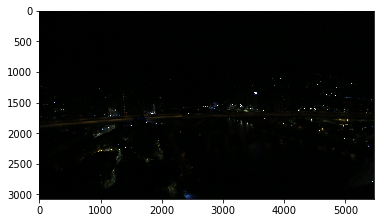

./images/nightsight/04.JPG
0.008


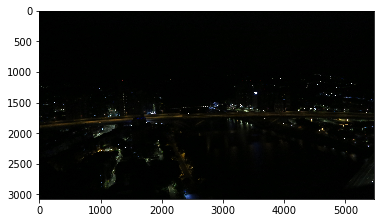

./images/nightsight/05.JPG
0.016666666666666666


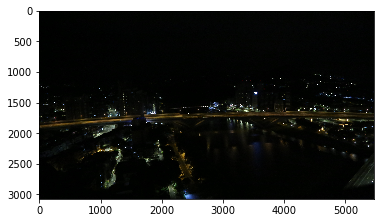

./images/nightsight/06.JPG
0.03333333333333333


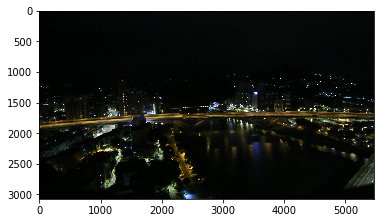

./images/nightsight/07.JPG
0.04


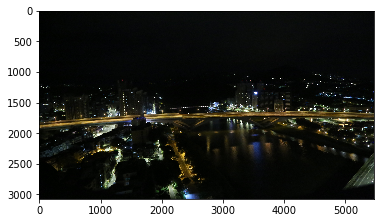

./images/nightsight/08.JPG
0.05


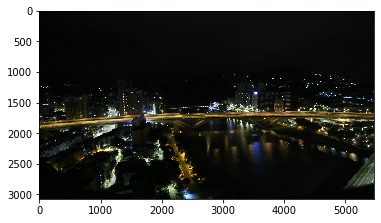

./images/nightsight/09.JPG
0.07692307692307693


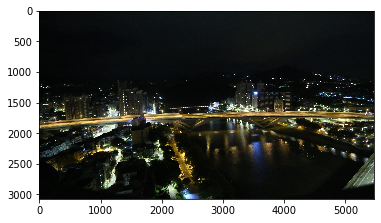

./images/nightsight/010.JPG
0.16666666666666666


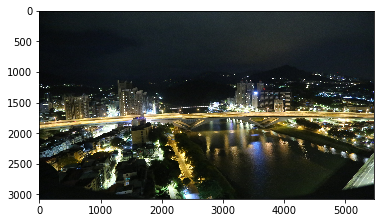

./images/nightsight/011.JPG
0.30000000000000004


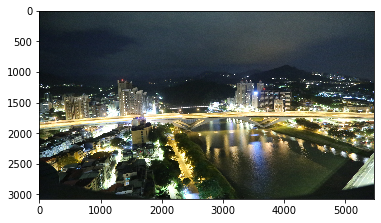

./images/nightsight/012.JPG
0.6000000000000001


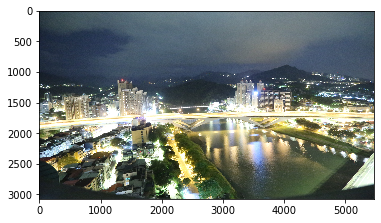

./images/nightsight/013.JPG
1.3


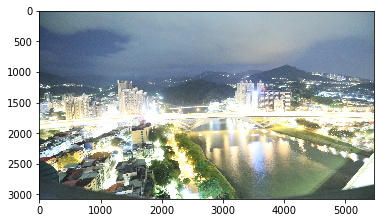

3072 5472 3


In [4]:
img_set = []
exposure_time.clear()

with open(op.join(data_path, 'shutter_speed.csv'), 'r') as fp:
    lines = fp.readlines()

    for line in lines:
        filename, shutter_speed = line.split(', ')
        

        # exposure time
        shutter_speed = shutter_speed.split('\"')
        if len(shutter_speed) == 2:
            exp_t = int(shutter_speed[0]) + 0.1*int(shutter_speed[1])
        else:
            exp_t = 1/int(shutter_speed[0])
        exposure_time.append(exp_t)

        # read image
        filepath = op.join(data_path, filename + img_type)
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_set.append(img)

        # display data
        print(filepath)
        print(exp_t)
        imshow(img)
        
img_set = np.array(img_set)

# parameters
num_imgs = len(img_set)
height, width, channels = img_set[0].shape
print(height, width, channels)


## Sample Pixel
Select pixels for recovering response curve.

In [5]:
num_pixels = 50
# sampled pixels
# should be in shape channels x num_pixels x num_imgs
sampled_pixels = np.array([])

# check if the number of pixels is enough to recover the response curve 
if num_pixels * (num_imgs-1) < 256:
    print('The number of pixels is not enough!')

In [20]:
# Random Sample
x_coords = np.random.randint(0, height, (num_pixels, 1))
y_coords = np.random.randint(0, width, (num_pixels, 1))
coords = np.concatenate((x_coords, y_coords), axis=1)
print(coords)

sampled_pixels = [[[img_set[j][coords[i, 0], coords[i, 1]][c] for j in range(num_imgs)] for i in range(num_pixels)] for c in range(channels)]
sampled_pixels = np.array(sampled_pixels)

print(np.shape(sampled_pixels))

[[1108 4198]
 [2958 5121]
 [1974 1455]
 [2083  434]
 [1498  780]
 [2806 5376]
 [1121 5271]
 [2342 4630]
 [1272 1862]
 [2004 2183]
 [2734 5454]
 [1462 2954]
 [1349  155]
 [1772  599]
 [2442 3995]
 [ 925 3104]
 [2363 4158]
 [1528 2170]
 [ 837 3395]
 [2639  802]
 [1499 5342]
 [1422 3659]
 [ 979 2926]
 [2285 4605]
 [2264  792]
 [1895  949]
 [1902 1472]
 [1475 2353]
 [2980 5028]
 [1618 5160]
 [1435 4065]
 [1025 3342]
 [1234  973]
 [ 374  217]
 [1444  303]
 [2324 3796]
 [1200 2909]
 [ 380 3854]
 [1195 1758]
 [ 135 2279]
 [1858 4365]
 [ 512  410]
 [2507  461]
 [2418 4289]
 [2800 2646]
 [ 141 3864]
 [1147   37]
 [ 261  160]
 [1030 1810]
 [1549 4779]]
(3, 50, 14)


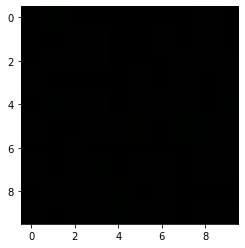

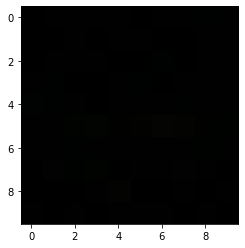

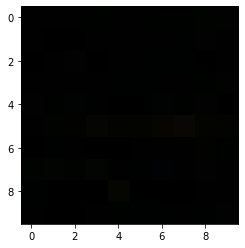

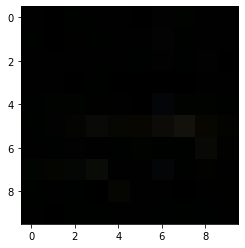

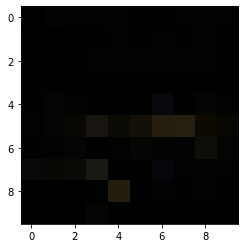

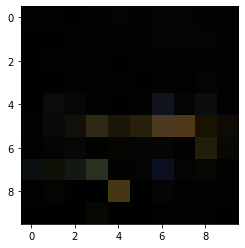

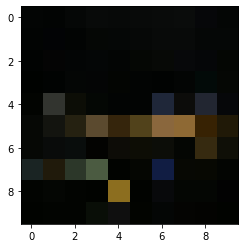

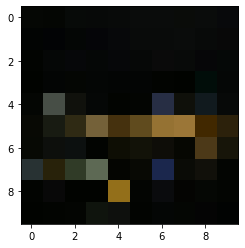

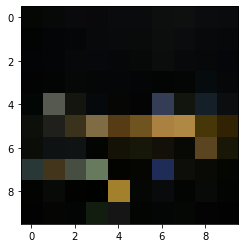

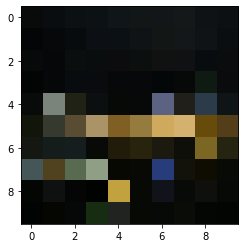

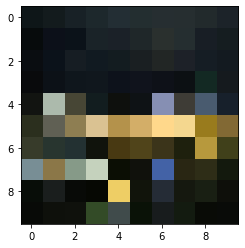

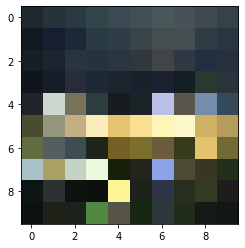

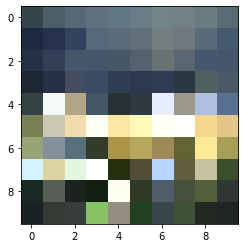

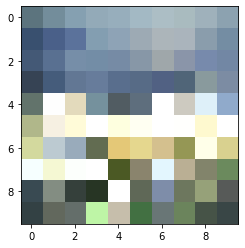

(3, 100, 14)


In [50]:
# Downsampling
size = (10, 10)
interpolation = cv2.INTER_LINEAR

channels = img_set.shape[3]
sampled_pixels = []
for img in img_set:
    ds_img = cv2.resize(img, size, interpolation=interpolation)
    imshow(ds_img)
    ds_vec = np.moveaxis(np.reshape(ds_img, (-1, channels, 1)), 1, 0)
    if len(sampled_pixels) > 0:
        sampled_pixels = np.concatenate((sampled_pixels, ds_vec), axis=2)
    else:
        sampled_pixels = ds_vec

sampled_pixels = np.array(sampled_pixels)
print(sampled_pixels.shape)

## Solve Response Curve 

(3, 256)


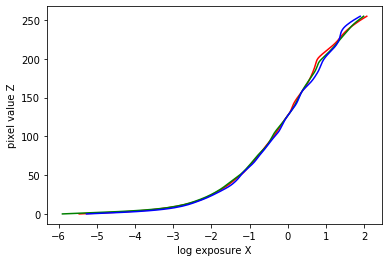

In [52]:
# Optimization
# response curve

def gsolve(Z, B, l, w):
    '''
    Assumes:
        Zmin = 0
        Zmax = 255

    Arguments:
        Z(c, i, j): sample pixel values at position i in image j of channel c
        B(j): log delta t(exposure time) of image j
        l: lambda, weighting regression term
        w(z): weighting function

    Returns:
        g(c, z): log exposure corresponding to pixel value z of chammel c
        lE(c, i): log irradiance at pixel position i of channel c
    '''

    g = []
    # lE = []

    # parameters
    n = 256 # intensity range
    channels, num_pixels, num_imgs = np.shape(Z)

    for c in range(channels):

        A = np.zeros((num_pixels * num_imgs + n + 1, n + num_pixels))
        b = np.zeros((A.shape[0], 1))

        
        k = 1 # current row of A
        for i in range(num_pixels):
            for j in range(num_imgs):
                # weight of current intensity
                wij = w[Z[c, i, j]]

                A[k, Z[c, i, j]] = wij
                A[k, n + i] = -wij
                b[k] = wij * B[j]

                k += 1

        # restrict 127 to be 0
        A[k, 127] = 1
        k += 1

        # smoothness term
        for i in range(n-2):
            lw = l * w[i+1]

            A[k, i] = lw
            A[k, i+1] = -2 * lw
            A[k, i+2] = lw

            k += 1
        
        # least-square solution for linear matrix equation
        x = np.linalg.lstsq(A, b, rcond=None)[0]
        g.append(x[:n])
        # lE.append(x[n+1:])

    return np.reshape(g, (channels, n))

# log exprosure time
ln_exp_time = np.log(exposure_time)
# hat weighting function
Zmin = 0
Zmax = 255
Zmed = (Zmin + Zmax)/2
hat_weight = np.array([z-Zmin if z <= Zmed else Zmax-z for z in range(256)])/int(Zmed)

g = gsolve(sampled_pixels, ln_exp_time, 30, hat_weight)
print(g.shape)

# plot
y_range = np.arange(256)
RGB = 'rgb'
for i in range(3):
    plt.plot(g[i], y_range, color=RGB[i])
plt.xlabel('log exposure X')
plt.ylabel('pixel value Z')
plt.savefig(op.join(data_path, 'response_curve.png'))

## Construct Radiance Map

In [22]:
# Construct Radiance Map
def HDR(Z, B, g, w):

    num_imgs, height, width, channels = np.shape(Z)
    lE = np.zeros((channels, height, width))

    '''
    # move axis version
    mZ = np.moveaxis(Z, [0, 3], [3, 0])
    for c in range(channels):
        wij = w[mZ[c]]
        lE[c] = np.sum(wij*(g[c, mZ[c]]-B), axis=-1) / np.sum(wij, axis=-1)
    
    '''
    # loop version
    progress = '0%'
    
    for c in range(channels):
        for x in range(height):
            for y in range(width):
                wij = w[Z[:, x, y, c]]
                swij = np.sum(wij)
                # check for overflow
                if swij == 0:
                    if np.all(Z[:, x, y, c] == 255):
                        lE[c, x, y] = np.inf
                    elif np.all(Z[:, x, y, c] == 0):
                        lE[c, x, y] = -np.inf
                    print(x, y, Z[:, x, y, c])
                else:
                    lE[c, x, y] = np.sum(wij * (g[c, Z[:, x, y, c]] - B)) / swij
            
            # display progress
            new_prog = '{}%'.format(int((c*height + x)/(channels*height) * 100))
            if new_prog != progress:
                progress = new_prog
                print(progress)
    
    # clip fix overflow
    for c in range(channels):
        lE[c, lE[c] == np.inf] = np.max(lE[c, lE[c] != np.inf])
        lE[c, lE[c] == -np.inf] = np.min(lE[c, lE[c] != -np.inf])
        
    # change from color major to row major
    lE = np.moveaxis(lE, 0, -1)
    lE = np.exp(lE)

    return lE

HDR_img = HDR(img_set, ln_exp_time, g, hat_weight)
print(HDR_img.shape)

1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
1028 5471 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12%
13%
14%
1325 5471 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
15%
16%
17%
18%
1668 1427 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1687 1077 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
3071 69 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3071 226 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3071 241 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3071 242 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3071 1149 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3071 1274 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
1336 3532 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1336 3550 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1337 3532 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
1340 3523 [255 255 255 255 255

In [129]:
# save HDR image
# convert to float32
HDR_f32 = HDR_img.astype(np.float32)
HDR_BGR = HDR_f32.copy()
# convert to BGR
HDR_BGR = HDR_BGR[:, :, ::-1]
print(HDR_f32[0, 0])
print(HDR_BGR[0, 0])
cv2.imwrite(op.join(data_path, 'radiance_map.hdr'), HDR_BGR)

[0.39200774 0.49978912 0.6422628 ]
[0.6422628  0.49978912 0.39200774]


True

[0.39200774 0.49978912 0.6422628 ]


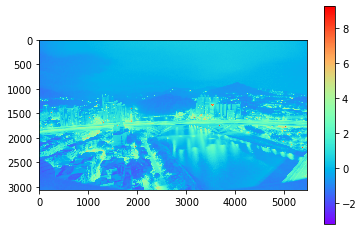

In [121]:
# heatmap of gray scale log space
print(HDR_f32[0, 0])
HDR_gray = np.sum(HDR_f32, axis=2)/3
plt.imshow(np.log(HDR_gray), 'rainbow')
plt.colorbar()
plt.show()

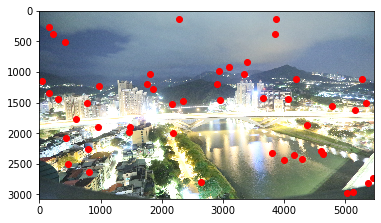

In [25]:
# sampled pixels
plt.plot(coords[:, 1], coords[:, 0], 'ro')
imshow(img_set[-1])

(3072, 5472, 3)
[0.640625   0.49609375 0.390625  ]
float32
-112.62158


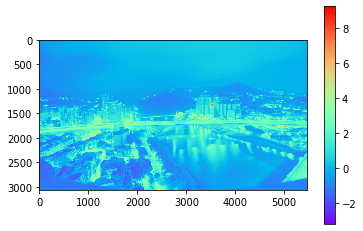

In [135]:
# reload radiance map
test = cv2.imread(op.join(data_path, 'radiance_map.hdr'), cv2.IMREAD_ANYDEPTH)

print(test.shape)
print(test[0, 0])
print(test.dtype)
print(np.min(test-HDR_BGR))

test_gray = np.sum(test, axis=2)/3
plt.imshow(np.log(test_gray), 'rainbow')
plt.colorbar()
plt.show()

In [150]:
tonemap = cv2.createTonemap(10)
ldr = tonemap.process(HDR_BGR)
cv2.imwrite(op.join(data_path, 'ldr.png'), ldr*255)

True

In [172]:
tonemap = cv2.createTonemapDrago(3, 0.8, 0.9)
ldr = tonemap.process(HDR_BGR)
cv2.imwrite(op.join(data_path, 'ldr_drago.png'), ldr*255)

True

In [151]:
tonemap = cv2.createTonemapMantiuk(5, 1)
ldr = tonemap.process(HDR_BGR)
cv2.imwrite(op.join(data_path, 'ldr_mantiuk.png'), ldr*255)

True

In [147]:
tonemap = cv2.createTonemapReinhard(2.2)
ldr = tonemap.process(HDR_BGR)
cv2.imwrite(op.join(data_path, 'ldr_reinhard.png'), ldr*255)

True

(3072, 5472, 3)


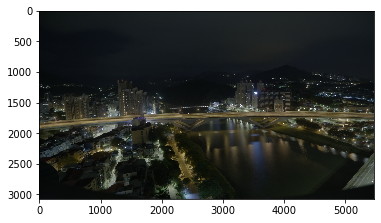

In [143]:
mean = np.mean(img_set, axis=0)
print(mean.shape)
imshow(mean.astype(np.uint8))